<a href="https://colab.research.google.com/github/sprical408/ML_Study/blob/main/GAN_Preview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 1 - 오토인코더 및 생성 학습

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist

In [2]:
# Set Parameter
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [6]:
# 잠재 공간에서 샘플링한 정보를 디코더에 주입하는 단계
# 평균과 표준편차를 학습하는 단계 라고 할 수 있다.
def sampling(args : tuple): # 튜플로 매개변수 설정

  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean = 0.,stddev= epsilon_std)

  return z_mean + K.exp(z_log_var / 2) * epsilon

In [8]:
# 인코더
x = Input(shape=(original_dim,), name = 'input')

# 중간 층
h = Dense(intermediate_dim, activation='relu', name = 'encoding')(x)

# 잠재 공간의 평균을 정의
z_mean = Dense(latent_dim,name='mean')(h)

# 잠재 공간의 로그 분산
z_log_var = Dense(latent_dim, name = 'log-variance')(h)

# 샘플링 함수
z = Lambda(sampling, output_shape = (latent_dim,))([z_mean, z_log_var])

# 케라스 모델로 인코더 정의
encoder = Model(x, [z_mean, z_log_var, z], name = 'encoder')

# 인코더 구조
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            514         encoding[0][0]                   
____________________________________________________________________________________________

In [10]:
# 디코더 입력
input_decoder = Input(shape = (latent_dim,), name = 'decoder_input')

# 잠재 공간을 중간 층의 차원으로 변환하기
decoder_h = Dense(intermediate_dim, activation='relu', name = 'decoder_h')(input_decoder)

# 초기 차원값으로부터 평균을 얻어내는 과정
x_decoded = Dense(original_dim, activation='sigmoid', name = 'flat_decoded')(decoder_h)

# 케라스 모듈로 정의
decoder = Model(input_decoder, x_decoded, name = "decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 인코더와 디코더 연결
output_combined = decoder(encoder(x)[2])

vae = Model(x, output_combined)

vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [12]:
# 손실 함수
kl_loss = -0.5 * K.sum(
    1 + z_log_var - K.exp(z_log_var) - K.square(z_mean),axis = -1
)

vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer='rmsprop', loss = "binary_crossentropy")
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 201988      input[0][0]                      
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          202256      encoder[0][2]                    
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
______________________________________________________________________________________________

In [14]:
# MNIST 데이터 활용
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train),np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test),np.prod(x_test.shape[1:])))

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# 크기 수정
vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size)

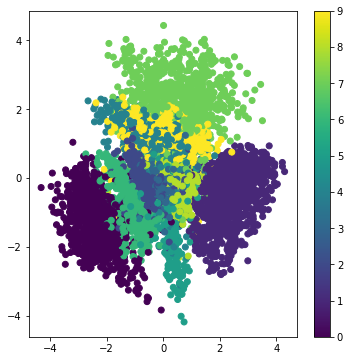

In [17]:
# 잠재 공간에 투영된 숫자 클래스의 2D 그래프
x_test_encoded = encoder.predict(x_test, batch_size = batch_size)[0]
plt.figure(figsize = (6,6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c = y_test, cmap = 'viridis')
plt.colorbar()
plt.show()

# 2. GAN 구현

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [5]:
img_rows = 28
img_cols = 28
channels = 1

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자 입력으로 사용될 잡음 벡터 크기
z_dim = 100

In [6]:
# 생성자 구현
def build_generator(img_shape, z_dim):
  model = Sequential()
  # 완전 연결 층
  model.add(Dense(128, input_dim = z_dim))
  # LeaktRelu 활성화 함수
  model.add(LeakyReLU(alpha=0.01))
  # tanh 활성화 함수를 사용한 출력 틍
  model.add(Dense(28 * 28 * 1, activation='tanh'))
  # 생성자의 출력을 이미지 차원으로 변경
  model.add(Reshape(img_shape))

  return model

In [7]:
# 판별자 구현
def build_discriminator(img_shape):
  model = Sequential()
  # 입력 이미지를 일렬로 펼치기
  model.add(Flatten(input_shape = img_shape))
  # 완전 연결 층
  model.add(Dense(128))
  # LeaktRelu
  model.add(LeakyReLU(alpha=0.01))
  # 시그모이드 활성화 함수를 사용한 출력층
  model.add(Dense(1, activation = 'sigmoid'))

  return model

In [8]:
# 생성자 + 판별자 = GAN 모델
def build_gan(generator, discriminator):
  model = Sequential()

  model.add(generator)
  model.add(discriminator)

  return model

In [9]:
# 모델 생성
generator = build_generator(img_shape, z_dim)

generator.summary()

discriminator = build_discriminator(img_shape)
discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = Adam(),
                      metrics = ['accuracy'])

discriminator.trainable = False

discriminator.summary()

gan = build_gan(generator,discriminator)

gan.summary()

gan.compile(loss = 'binary_crossentropy', optimizer = Adam())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               101136    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
____________________________

In [14]:
# 훈련
losses = []
accs = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

  (x_train, _),(_,_) = mnist.load_data()

  x_train = x_train / 127.5 - 1.0
  x_train = np.expand_dims(x_train, axis = 3)

  real = np.ones((batch_size, 1))

  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):

    idx = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[idx]

    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    d_loss, acc = 0.5 * np.add(d_loss_real, d_loss_fake)


    z = np.random.normal(0,1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    g_loss = gan.train_on_batch(z,real)

    if (iteration + 1) % sample_interval == 0:

      losses.append((d_loss, g_loss))
      accs.append(100.0 * acc)
      iteration_checkpoints.append(iteration + 1)

      print("%d [D loss : %f, acc : %.2f%%] [G loss : %f]" % (iteration+1, d_loss, 100.0 * acc, g_loss))

      sample_images(generator)


In [11]:

def sample_images(generator, image_grid_rows = 4, image_grid_columns = 4):

  z = np.random.normal(0,1, (image_grid_rows * image_grid_columns, z_dim))

  gen_imgs = generator.predict(z)

  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize = (4,4), sharey= True, sharex=True)

  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      # 이미지 그리드 출력
      print("%d Step" % (cnt+1))
      axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap = 'gray')
      axs[i,j].axis('off')
      cnt += 1

1000 [D loss : 0.180338, acc : 93.75%] [G loss : 3.990185]
1 Step
2 Step
3 Step
4 Step
5 Step
6 Step
7 Step
8 Step
9 Step
10 Step
11 Step
12 Step
13 Step
14 Step
15 Step
16 Step
2000 [D loss : 0.078317, acc : 97.27%] [G loss : 6.583860]
1 Step
2 Step
3 Step
4 Step
5 Step
6 Step
7 Step
8 Step
9 Step
10 Step
11 Step
12 Step
13 Step
14 Step
15 Step
16 Step
3000 [D loss : 0.161686, acc : 93.75%] [G loss : 6.833745]
1 Step
2 Step
3 Step
4 Step
5 Step
6 Step
7 Step
8 Step
9 Step
10 Step
11 Step
12 Step
13 Step
14 Step
15 Step
16 Step
4000 [D loss : 0.173241, acc : 93.75%] [G loss : 5.404335]
1 Step
2 Step
3 Step
4 Step
5 Step
6 Step
7 Step
8 Step
9 Step
10 Step
11 Step
12 Step
13 Step
14 Step
15 Step
16 Step
5000 [D loss : 0.275597, acc : 89.45%] [G loss : 4.467690]
1 Step
2 Step
3 Step
4 Step
5 Step
6 Step
7 Step
8 Step
9 Step
10 Step
11 Step
12 Step
13 Step
14 Step
15 Step
16 Step
6000 [D loss : 0.286631, acc : 87.89%] [G loss : 4.719085]
1 Step
2 Step
3 Step
4 Step
5 Step
6 Step
7 Step
8 

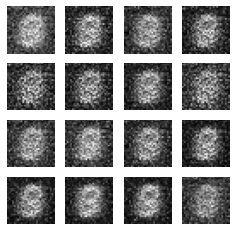

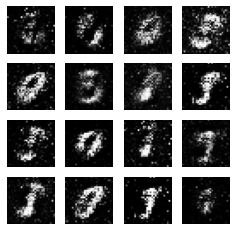

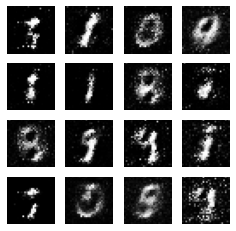

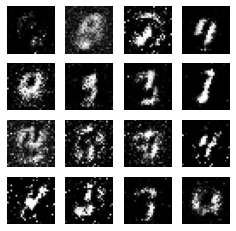

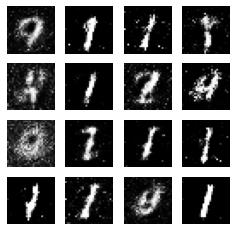

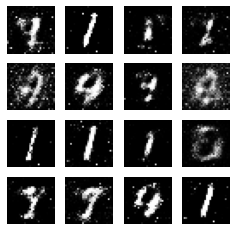

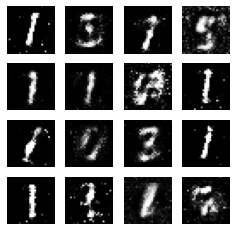

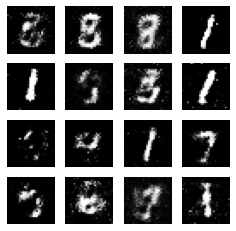

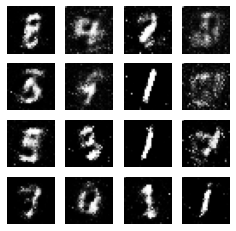

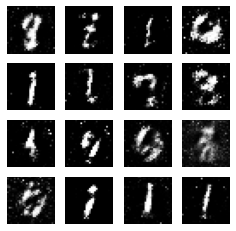

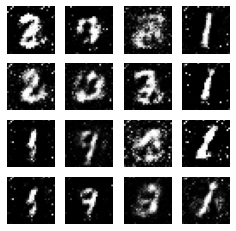

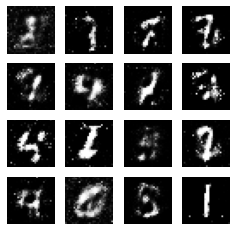

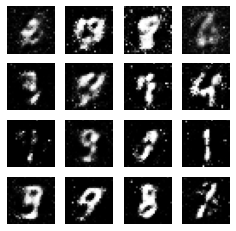

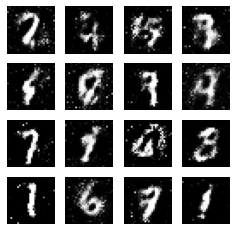

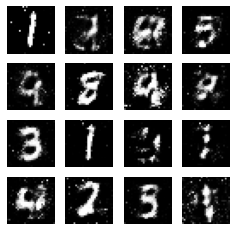

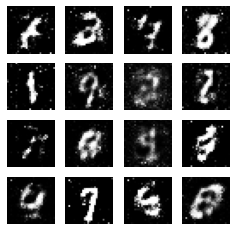

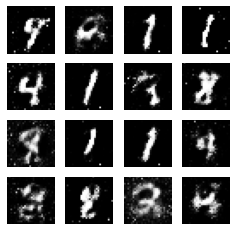

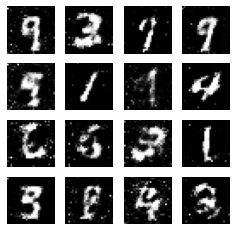

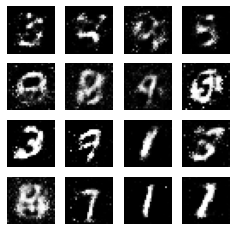

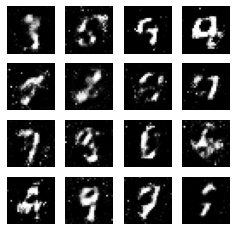

In [15]:

iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

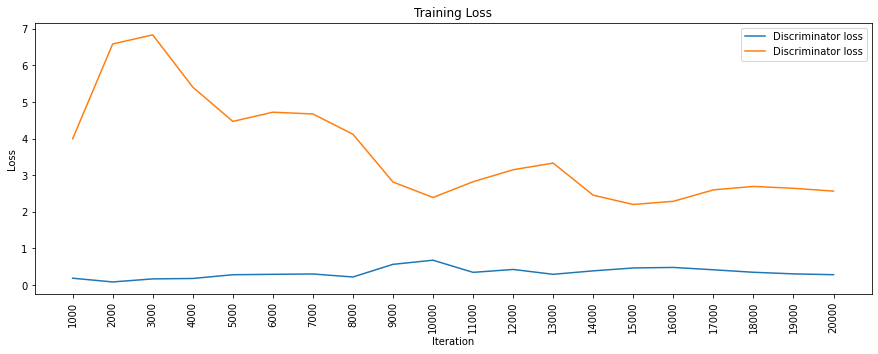

In [16]:
losses = np.array(losses)

plt.figure(figsize = (15,5))
plt.plot(iteration_checkpoints, losses.T[0], label = "Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label = "Discriminator loss")

plt.xticks(iteration_checkpoints, rotation = 90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

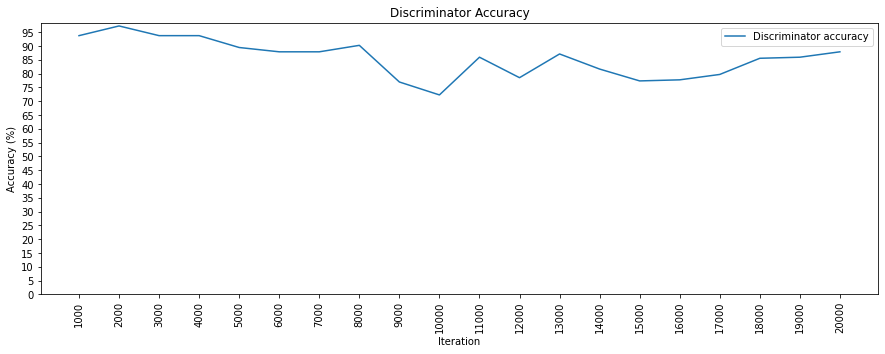

In [18]:
accs = np.array(accs)

plt.figure(figsize = (15,5))
plt.plot(iteration_checkpoints, accs, label = "Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation = 90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()